In [1]:
import flwr as fl
import pydicom, re
import tensorflow as tf
import pandas as pd
import numpy as np
import flwr as fl
from os import listdir
from os.path import isfile, join, exists

In [2]:
class MRIDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, X_col, y_col, batch_size,
                 input_size= (256, 256), depth_size=64,
                 shuffle=True):
 
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.depth_size = depth_size
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        self.n = len(self.df)
 
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
 
    def __get_input(self, path, target_size):
        scan3d = None
        onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]
        filepatt = 'Image-{}.dcm'
        digits = [int(re.search('\d+',i).group()) for i in listdir(path) if re.match(filepatt.format('\d+\\'),i)]
        digits.sort()
        onlyfiles = [filepatt.format(dig) for dig in digits]
        
        center = len(onlyfiles) // 2
        left = max(0, center - (self.depth_size // 2))
        right = min(len(onlyfiles), center + (self.depth_size // 2))
        onlyfiles = onlyfiles[left: right]
        if len(onlyfiles) < self.depth_size:
            img_shape = pydicom.read_file(f'{path}{onlyfiles[0]}').pixel_array.shape
            add_z = self.depth_size - len(onlyfiles)
            scan3d = np.zeros((add_z, target_size[0], target_size[1],1))
        
            
        scans = []
        for f in onlyfiles:
            img = pydicom.read_file(f'{path}{f}')
            img = img.pixel_array
            img = self._rescale(img)
            img = np.expand_dims(img, axis=-1)
            img = tf.image.resize(img,(target_size[0], target_size[1])).numpy()
            
            img = self._normalize(img)
            scans.append(img)
        
        if scan3d is not None:
            return np.concatenate([np.array(scans), scan3d]) 
        else:
            return np.array(scans)
    def _rescale(self, arr):
        arr_min = arr.min()
        arr_max = arr.max()
        if (arr_max - arr_min) == 0:
            return arr
        return (arr - arr_min) / (arr_max - arr_min)
    def _normalize(self, arr):
        img = arr - arr.mean()
        # divide by the standard deviation (only if it is different from zero)
        if np.std(img) != 0:
            img = img / np.std(img)
        return img
    def __get_data(self, batches):
        if self.X_col is None:
            PATHS = ['FLAIR_path', 'T1w_path', 'T2w_path', 'T1wCE_path']
            X_batch = []
            for p in PATHS:
                batch_part_path = batches[p]
                X_batch.append(np.asarray([self.__get_input(x,  self.input_size) for x in batch_part_path]))
            y_batch = batches[self.y_col].values
            X_batch = np.concatenate(X_batch, axis=4)
            
        else:
            path_batch = batches[self.X_col]
            X_batch = np.asarray([self.__get_input(x,  self.input_size) for x in path_batch])
            y_batch = batches[self.y_col].values
        return X_batch, y_batch
    def __getitem__(self, index):
        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__get_data(batches)
        return X, y
    def __len__(self):
        return self.n // self.batch_size 

In [3]:
def checkDirectoryForExistence(dirName):
    return exists(f'./server_val_data/{str(dirName).zfill(5)}')

def getAllExistingDirs():
    return f'./server_val_data/' + test_df[test_df['BraTS21ID'].apply(checkDirectoryForExistence)]['BraTS21ID'].astype(str).str.zfill(5)

test_df = pd.read_csv(f"./train_labels.csv")
test_df['FLAIR_path'] = getAllExistingDirs() + '/FLAIR/'
test_df['T1w_path'] = getAllExistingDirs() + '/T1w/' 
test_df['T2w_path'] = getAllExistingDirs() + '/T2w/' 
test_df['T1wCE_path'] = getAllExistingDirs() + '/t1wCE/'
test_df = test_df.dropna(how='any')

In [4]:
depth = 64
resolution = (192, 192)
batches = 4

val_loss = []
val_acc = []

def get_eval_fn(model):
    """Return an evaluation function for server-side evaluation."""

    # The `evaluate` function will be called after every round
    def evaluate(weights: fl.common.Weights):
        model.set_weights(weights)  # Update model with the latest parameters
        loss, accuracy = model.evaluate(MRIDataGenerator(test_df, 'FLAIR_path', 'MGMT_value', batches, resolution, depth, True))
        val_loss.append(loss)
        val_acc.append(accuracy)
        return loss, {"accuracy": accuracy}

    return evaluate

In [5]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense

model = Sequential()
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(64,192, 192, 1)))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Conv3D(256, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='sigmoid'))

model.compile(
        optimizer='adam', 
        loss='binary_crossentropy',
        metrics=[tf.keras.metrics.BinaryAccuracy()]
    )

In [6]:
strategy = fl.server.strategy.FedAvg(
    # ... other FedAvg agruments
    fraction_eval=1,
    min_eval_clients=4,
    min_available_clients=4,
    fraction_fit=1,
    min_fit_clients=4,
    eval_fn=get_eval_fn(model)
)

In [7]:
fl.server.start_server(config={"num_rounds": 10}, strategy=strategy)

INFO flower 2022-05-26 21:24:28,524 | app.py:134 | Flower server running (10 rounds), SSL is disabled
INFO flower 2022-05-26 21:24:28,526 | server.py:84 | Initializing global parameters
INFO flower 2022-05-26 21:24:28,526 | server.py:256 | Requesting initial parameters from one random client
INFO flower 2022-05-26 21:24:36,079 | server.py:259 | Received initial parameters from one random client
INFO flower 2022-05-26 21:24:36,079 | server.py:86 | Evaluating initial parameters


20/20 [==============================] - 95s 5s/step - loss: 1.9726 - binary_accuracy: 0.5250


INFO flower 2022-05-26 21:26:19,183 | server.py:89 | initial parameters (loss, other metrics): 1.9725606441497803, {'accuracy': 0.5249999761581421}
INFO flower 2022-05-26 21:26:19,184 | server.py:99 | FL starting
DEBUG flower 2022-05-26 21:26:19,184 | server.py:203 | fit_round: strategy sampled 4 clients (out of 4)
DEBUG flower 2022-05-26 21:42:16,486 | server.py:216 | fit_round received 4 results and 0 failures
WARNING flower 2022-05-26 21:42:16,809 | fedavg.py:237 | No fit_metrics_aggregation_fn provided


20/20 [==============================] - 94s 5s/step - loss: 0.6918 - binary_accuracy: 0.5250


INFO flower 2022-05-26 21:43:58,644 | server.py:114 | fit progress: (1, 0.6917809247970581, {'accuracy': 0.5249999761581421}, 1059.3053749)
DEBUG flower 2022-05-26 21:43:58,647 | server.py:157 | evaluate_round: strategy sampled 4 clients (out of 4)
DEBUG flower 2022-05-26 21:46:01,479 | server.py:170 | evaluate_round received 4 results and 0 failures
WARNING flower 2022-05-26 21:46:01,480 | fedavg.py:268 | No evaluate_metrics_aggregation_fn provided
DEBUG flower 2022-05-26 21:46:01,481 | server.py:203 | fit_round: strategy sampled 4 clients (out of 4)
DEBUG flower 2022-05-26 22:01:54,414 | server.py:216 | fit_round received 4 results and 0 failures


20/20 [==============================] - 94s 5s/step - loss: 0.6941 - binary_accuracy: 0.4625


INFO flower 2022-05-26 22:03:36,458 | server.py:114 | fit progress: (2, 0.6940613985061646, {'accuracy': 0.4625000059604645}, 2236.9882475000004)
DEBUG flower 2022-05-26 22:03:36,474 | server.py:157 | evaluate_round: strategy sampled 4 clients (out of 4)
DEBUG flower 2022-05-26 22:05:38,492 | server.py:170 | evaluate_round received 4 results and 0 failures
DEBUG flower 2022-05-26 22:05:38,493 | server.py:203 | fit_round: strategy sampled 4 clients (out of 4)
DEBUG flower 2022-05-26 22:21:34,672 | server.py:216 | fit_round received 4 results and 0 failures


20/20 [==============================] - 94s 5s/step - loss: 0.7028 - binary_accuracy: 0.4875


INFO flower 2022-05-26 22:23:16,626 | server.py:114 | fit progress: (3, 0.702825665473938, {'accuracy': 0.48750001192092896}, 3417.0414081999998)
DEBUG flower 2022-05-26 22:23:16,627 | server.py:157 | evaluate_round: strategy sampled 4 clients (out of 4)
DEBUG flower 2022-05-26 22:25:19,403 | server.py:170 | evaluate_round received 4 results and 0 failures
DEBUG flower 2022-05-26 22:25:19,403 | server.py:203 | fit_round: strategy sampled 4 clients (out of 4)
DEBUG flower 2022-05-26 22:41:08,843 | server.py:216 | fit_round received 4 results and 0 failures


20/20 [==============================] - 94s 5s/step - loss: 0.6937 - binary_accuracy: 0.5000


INFO flower 2022-05-26 22:42:50,759 | server.py:114 | fit progress: (4, 0.6937116384506226, {'accuracy': 0.5}, 4591.1573112)
DEBUG flower 2022-05-26 22:42:50,770 | server.py:157 | evaluate_round: strategy sampled 4 clients (out of 4)
DEBUG flower 2022-05-26 22:44:52,477 | server.py:170 | evaluate_round received 4 results and 0 failures
DEBUG flower 2022-05-26 22:44:52,479 | server.py:203 | fit_round: strategy sampled 4 clients (out of 4)
DEBUG flower 2022-05-26 23:00:41,855 | server.py:216 | fit_round received 4 results and 0 failures


20/20 [==============================] - 94s 5s/step - loss: 0.8202 - binary_accuracy: 0.5375


INFO flower 2022-05-26 23:02:24,049 | server.py:114 | fit progress: (5, 0.8201594352722168, {'accuracy': 0.5375000238418579}, 5764.2516219)
DEBUG flower 2022-05-26 23:02:24,049 | server.py:157 | evaluate_round: strategy sampled 4 clients (out of 4)
DEBUG flower 2022-05-26 23:04:26,705 | server.py:170 | evaluate_round received 4 results and 0 failures
DEBUG flower 2022-05-26 23:04:26,706 | server.py:203 | fit_round: strategy sampled 4 clients (out of 4)
DEBUG flower 2022-05-26 23:20:18,964 | server.py:216 | fit_round received 4 results and 0 failures


20/20 [==============================] - 94s 5s/step - loss: 0.6899 - binary_accuracy: 0.5375


INFO flower 2022-05-26 23:22:00,797 | server.py:114 | fit progress: (6, 0.6899438500404358, {'accuracy': 0.5375000238418579}, 6940.8671484999995)
DEBUG flower 2022-05-26 23:22:00,798 | server.py:157 | evaluate_round: strategy sampled 4 clients (out of 4)
DEBUG flower 2022-05-26 23:24:03,354 | server.py:170 | evaluate_round received 4 results and 0 failures
DEBUG flower 2022-05-26 23:24:03,355 | server.py:203 | fit_round: strategy sampled 4 clients (out of 4)
DEBUG flower 2022-05-26 23:39:53,883 | server.py:216 | fit_round received 4 results and 0 failures


20/20 [==============================] - 94s 5s/step - loss: 0.6954 - binary_accuracy: 0.4875


INFO flower 2022-05-26 23:41:35,864 | server.py:114 | fit progress: (7, 0.69538414478302, {'accuracy': 0.48750001192092896}, 8115.8730391)
DEBUG flower 2022-05-26 23:41:35,864 | server.py:157 | evaluate_round: strategy sampled 4 clients (out of 4)
DEBUG flower 2022-05-26 23:43:37,917 | server.py:170 | evaluate_round received 4 results and 0 failures
DEBUG flower 2022-05-26 23:43:37,918 | server.py:203 | fit_round: strategy sampled 4 clients (out of 4)
DEBUG flower 2022-05-26 23:59:26,802 | server.py:216 | fit_round received 4 results and 0 failures


20/20 [==============================] - 94s 5s/step - loss: 0.6910 - binary_accuracy: 0.5250


INFO flower 2022-05-27 00:01:08,578 | server.py:114 | fit progress: (8, 0.6910039186477661, {'accuracy': 0.5249999761581421}, 9288.4633969)
DEBUG flower 2022-05-27 00:01:08,578 | server.py:157 | evaluate_round: strategy sampled 4 clients (out of 4)
DEBUG flower 2022-05-27 00:03:11,085 | server.py:170 | evaluate_round received 4 results and 0 failures
DEBUG flower 2022-05-27 00:03:11,085 | server.py:203 | fit_round: strategy sampled 4 clients (out of 4)
DEBUG flower 2022-05-27 00:18:59,224 | server.py:216 | fit_round received 4 results and 0 failures


20/20 [==============================] - 94s 5s/step - loss: 0.6887 - binary_accuracy: 0.5250


INFO flower 2022-05-27 00:20:40,946 | server.py:114 | fit progress: (9, 0.6886682510375977, {'accuracy': 0.5249999761581421}, 10460.689007300001)
DEBUG flower 2022-05-27 00:20:40,946 | server.py:157 | evaluate_round: strategy sampled 4 clients (out of 4)
DEBUG flower 2022-05-27 00:22:43,184 | server.py:170 | evaluate_round received 4 results and 0 failures
DEBUG flower 2022-05-27 00:22:43,184 | server.py:203 | fit_round: strategy sampled 4 clients (out of 4)
DEBUG flower 2022-05-27 00:38:25,322 | server.py:216 | fit_round received 4 results and 0 failures


20/20 [==============================] - 94s 5s/step - loss: 0.6898 - binary_accuracy: 0.5375


INFO flower 2022-05-27 00:40:07,038 | server.py:114 | fit progress: (10, 0.6898452043533325, {'accuracy': 0.5375000238418579}, 11626.7289891)
DEBUG flower 2022-05-27 00:40:07,044 | server.py:157 | evaluate_round: strategy sampled 4 clients (out of 4)
DEBUG flower 2022-05-27 00:42:09,015 | server.py:170 | evaluate_round received 4 results and 0 failures
INFO flower 2022-05-27 00:42:09,016 | server.py:138 | FL finished in 11748.658392500001
INFO flower 2022-05-27 00:42:09,040 | app.py:178 | app_fit: losses_distributed [(1, 0.6986111431167676), (2, 0.6910489579805961), (3, 0.6897228480531619), (4, 0.6940656080842018), (5, 0.7735212290516267), (6, 0.7117360394734603), (7, 0.7054867377647986), (8, 0.7096480910594647), (9, 0.7104842949372071), (10, 0.7031079427554057)]
INFO flower 2022-05-27 00:42:09,040 | app.py:179 | app_fit: metrics_distributed {}
INFO flower 2022-05-27 00:42:09,041 | app.py:180 | app_fit: losses_centralized [(0, 1.9725606441497803), (1, 0.6917809247970581), (2, 0.6940613

History (loss, distributed):
	round 1: 0.6986111431167676
	round 2: 0.6910489579805961
	round 3: 0.6897228480531619
	round 4: 0.6940656080842018
	round 5: 0.7735212290516267
	round 6: 0.7117360394734603
	round 7: 0.7054867377647986
	round 8: 0.7096480910594647
	round 9: 0.7104842949372071
	round 10: 0.7031079427554057
History (loss, centralized):
	round 0: 1.9725606441497803
	round 1: 0.6917809247970581
	round 2: 0.6940613985061646
	round 3: 0.702825665473938
	round 4: 0.6937116384506226
	round 5: 0.8201594352722168
	round 6: 0.6899438500404358
	round 7: 0.69538414478302
	round 8: 0.6910039186477661
	round 9: 0.6886682510375977
	round 10: 0.6898452043533325
History (metrics, centralized):
{'accuracy': [(0, 0.5249999761581421), (1, 0.5249999761581421), (2, 0.4625000059604645), (3, 0.48750001192092896), (4, 0.5), (5, 0.5375000238418579), (6, 0.5375000238418579), (7, 0.48750001192092896), (8, 0.5249999761581421), (9, 0.5249999761581421), (10, 0.5375000238418579)]}

In [12]:
loss_centralized = [1.9725606441497803, 0.6917809247970581, 0.6940613985061646, 0.702825665473938, 0.6937116384506226, 0.8201594352722168, 0.6899438500404358, 0.69538414478302, 0.6910039186477661, 0.6886682510375977, 0.6898452043533325]
loss_distributed = [0.6986111431167676, 0.6910489579805961, 0.6897228480531619, 0.6940656080842018, 0.7735212290516267, 0.7117360394734603, 0.7054867377647986, 0.7096480910594647, 0.7104842949372071, 0.7031079427554057]

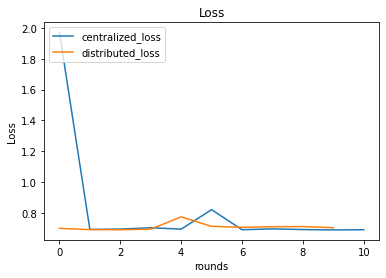

In [15]:
import matplotlib.pyplot as plt
plt.plot(loss_centralized)
plt.plot(loss_distributed)
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('rounds')
plt.legend(['centralized_loss', 'distributed_loss'], loc='upper left')
plt.show()